# 2023-11-03 Applied Finite Elements

## Last time

* libCEED abstraction
* Restriction to elements
* Nonlinear problems and the QFunction abstraction

## Today

* Advection-diffusion
* Stabilized methods for transport
  * VMS and SUPG
* FE interfaces

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature
import NLsolve: nlsolve

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

function febasis(P, Q, quadrature=gausslegendre)
    x, _ = gausslobatto(P)
    q, w = quadrature(Q)
    Pk, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / Pk
    D = Dp / Pk
    x, q, w, B, D
end

function fe1_mesh(P, nelem)
    x = LinRange(-1, 1, nelem+1)
    rows = Int[]
    cols = Int[]
    for i in 1:nelem
        append!(rows, (i-1)*P+1:i*P)
        append!(cols, (i-1)*(P-1)+1:i*(P-1)+1)
    end
    x, sparse(cols, rows, ones(nelem*P))'
end

function xnodal(x, P)
    xn = Float64[]
    xref, _ = gausslobatto(P)
    for i in 1:length(x)-1
        xL, xR = x[i:i+1]
        append!(xn, (xL+xR)/2 .+ (xR-xL)/2 * xref[1+(i>1):end])
    end
    xn
end

struct FESpace
    P::Int
    Q::Int
    nelem::Int
    x::Vector
    xn::Vector
    Et::SparseMatrixCSC{Float64, Int64}
    q::Vector
    w::Vector
    B::Matrix
    D::Matrix
    function FESpace(P, Q, nelem, quadrature=gausslegendre)
        x, E = fe1_mesh(P, nelem)
        xn = xnodal(x, P)
        _, q, w, B, D = febasis(P, Q, quadrature)
        new(P, Q, nelem, x, xn, E', q, w, B, D)
    end
end

# Extract out what we need for element e
function fe_element(fe, e)
    xL, xR = fe.x[e:e+1]
    q = (xL+xR)/2 .+ (xR-xL)/2*fe.q
    w = (xR - xL)/2 * fe.w
    E = fe.Et[:, (e-1)*fe.P+1:e*fe.P]'
    dXdx = ones(fe.Q) * 2 / (xR - xL)
    q, w, E, dXdx
end

function fe_residual(u_in, fe, fq; bci=[1], bcv=[1.])
    u = copy(u_in); v = zero(u)
    u[bci] = bcv
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D = fe.B, fe.D
        ue = E * u
        uq = B * ue
        Duq = dXdx .* (D * ue)
        f0, f1 = fq(q, uq, Duq)
        ve = B' * (w .* f0) + D' * (dXdx .* w .* f1)
        v += E' * ve
    end
    v[bci] = u_in[bci] - u[bci]
    #println("residual")
    v
end

function fe_jacobian(u_in, fe, dfq; bci=[1], bcv=[1.])
    u = copy(u_in); u[bci] = bcv
    rows, cols, vals = Int[], Int[], Float64[]
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D, P = fe.B, fe.D, fe.P
        ue = E * u
        uq = B * ue; Duq = dXdx .* (D * ue)
        K = zeros(P, P)
        for j in 1:fe.P
            du = B[:,j]
            Ddu = dXdx .* D[:,j]
            df0, df1 = dfq(q, uq, du, Duq, Ddu)
            K[:,j] = B' * (w .* df0) + D' * (dXdx .* w .* df1)
        end
        inds = rowvals(E')
        append!(rows, kron(ones(P), inds))
        append!(cols, kron(inds, ones(P)))
        append!(vals, vec(K))
    end
    A = sparse(rows, cols, vals)
    A[bci, :] .= 0; A[:, bci] .= 0
    A[bci,bci] = diagm(ones(length(bci)))
    A
end

fe_jacobian (generic function with 1 method)

# Advection-diffusion (time independent)

\begin{align}
\mathbf w \cdot \nabla u - \nabla\cdot\big[ \kappa \nabla u \big] &= s & \int_\Omega v \mathbf w \cdot \nabla u + \int_\Omega \nabla v \cdot \kappa \nabla u  &= \int_\Omega v s, \forall v
\end{align}

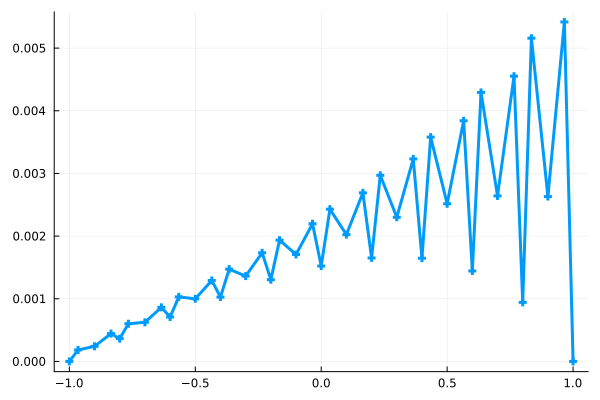

In [2]:
wind = 500 
fq(q, u, Du) = wind .* Du -one.(u), 1 * Du

fe = FESpace(5, 5, 10)
u0 = zero(fe.xn)
N = length(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq; bci=[1, N], bcv=[0, 0]), zero(fe.xn), method=:newton)
plot(fe.xn, sol.zero, marker=:auto, legend=:none)

# Artificial diffusion and Streamline Upwinding

Observation: the residual is large where diffusion is needed.

$$\underbrace{\int_\Omega v \mathbf w \cdot \nabla u + \int_\Omega \nabla v \cdot \kappa \nabla u - \int_\Omega v s}_{\text{Galerkin}} + \int_\Omega (\mathbf w \cdot \nabla v) \tau^e \big(\underbrace{\mathbf w \cdot \nabla u - \nabla\cdot(\kappa\nabla u) - s}_{\text{strong form residual}}\big)$$

## Examine what this does to advection

$$(\mathbf w \cdot \nabla v)(\mathbf w \cdot \nabla u) = \nabla v (\mathbf w \otimes \mathbf w) \nabla u$$

This is "pencil" shaped diffusion, only along the streamline. If $\tau^e$ is chosen appropriately, this will be enough diffusion to get a Peclet number of about 1 when it needs it.

## Optimal stabilization
A nodally exact solution for 1D advection.
$$ \tau^e = \frac{h}{2 \lVert \mathbf w \rVert} \Big( \coth Pe - \frac{1}{Pe} \Big)$$

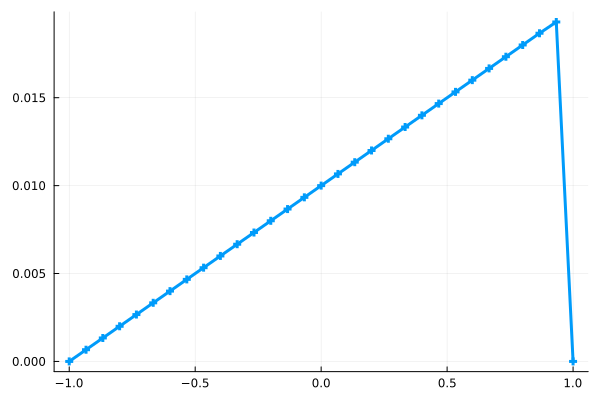

In [3]:
wind = 100; k = 1
fq(q, u, Du) = wind .* Du -one.(u), k * Du + tau * wind.^2 .* Du

n = 30; h = 2 / n; Pe = abs(wind) * h / (2 * k)
tau = h / (2 * abs(wind)) * (coth(Pe) - 1 / Pe)
fe = FESpace(2, 2, n)
u0 = zero(fe.xn)
N = length(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq; bci=[1, N], bcv=[0, 0]), zero(fe.xn), method=:newton)
plot(fe.xn, sol.zero, marker=:auto, legend=:none)

# Variational Multiscale key ideas

Suppose we have the strong and weak forms
\begin{align}
u_t + F(u) &= 0 & \langle v, u_t \rangle + a(v,u) &= 0
\end{align}
where $L = \partial F/\partial u$. For advection-diffusion, $L u = \mathbf w \cdot \nabla u - \nabla\cdot(\kappa \nabla u)$.

Decompose the solution into a resolved and oscillatory part $u = \bar u + \tilde u$ and similar for $v = \bar v + \tilde v$.
\begin{align}
\langle \bar v, \bar u_t + \tilde u_t \rangle + a(\bar v, \bar u + \tilde u) & = 0 \\
\langle \tilde v, \bar u_t + \tilde u_t \rangle + a(\tilde v, \bar u + \tilde u) & = 0 
\end{align}

We approximate via first order Taylor series
\begin{align}
a(\bar v, \bar u + \tilde u) &\approx a(\bar v, \bar u) + \langle \bar v, L \tilde u \rangle \\
&= a(\bar v, \bar u) + \langle L^* \bar v, \tilde u \rangle \\
a(\tilde v, \bar u + \tilde u) &\approx \langle \tilde v, F(\bar u) \rangle + \langle \tilde v, L \tilde u \rangle
\end{align}
where we prefer the forms in which $L$ or its adjoint, $L^*$, is applied to the smoother of the two functions.

## Subgrid ansatz
$\tilde u$ can be obtained by solving
$$\langle \tilde v, L \tilde u \rangle = -\langle \tilde v, \bar u_t + \tilde u_t + F(\bar u) \rangle$$
but these are all unresolved scales. Assuming quasistatic fluctuations $\tilde u_t = 0$, the ansatz $\tau \approx L^{-1}$ gives
$$\tilde u = -\tau (\bar u_t + F(\bar u))$$
and thus the stabilized form entirely in terms of resolved scales.
$$\underbrace{\langle \bar v, \bar u_t \rangle + a(\bar v, \bar u)}_{\text{Galerkin}} - \langle L^* \bar v, \tau (\bar u_t + F(\bar u)) \rangle$$
Expressions for $\tau$ can be obtained by local problems or Fourier analysis.

# Stabilized methods for advection-diffusion

\begin{align}
L u &= \mathbf w \cdot \nabla u - \nabla\cdot(\kappa \nabla u) &
L^* u &= -\mathbf w \cdot \nabla u - \nabla\cdot(\kappa \nabla u)
\end{align}

## Variational Multiscale [1998](https://doi.org/10.1016/S0045-7825(98)00079-6)

$$\underbrace{\langle \bar v, \bar u_t \rangle + a(\bar v, \bar u)}_{\text{Galerkin}} - \langle L^* \bar v, \tau (\bar u_t + F(\bar u)) \rangle$$
* Stabilization is not symmetric
* Involves diffusion operator applied to test function, but basis functions are only $C^0$ (discontinuous derivatives).
* Properly applied as a space-time method, not method of lines (so doesn't work with off-the-shelf ODE integrators).
* Explains preferred $L$ vs $L^*$ for hyperbolic systems with nonsymmetric flux Jacobian.

## Galerkin Least-Squares [1991](https://doi.org/10.1016/0045-7825(91)90041-4)
$$\langle \bar v, \bar u_t \rangle + a(\bar v, \bar u) + \langle L \bar v, \tau (\bar u_t + F(\bar u)) \rangle$$
* SPD stabilization (convenient for theory)
* A space-time method when done properly.
* Less accurate than VMS in practice.

## SUPG [1982](https://doi.org/10.1016/0045-7825(82)90071-8)
$$\langle \bar v, \bar u_t \rangle + a(\bar v, \bar u) - \langle L^*_{\text{adv}} \bar v, \tau (\bar u_t + F(\bar u)) \rangle$$

* [**Streamline upwind Petrov-Galerkin** is misleading](https://doi.org/10.1002/fld.1650071108)
* Easy to implement with method of lines
* **SU** variant even simpler; only first order.

# Time dependent problems

1. Start with a time dependent problem in strong form
$$ u_t + \nabla\cdot (\mathbf w u - \kappa \nabla u) = 0 .$$
2. Multiply by a test function $v$ and integrate
$$ \int_\Omega \Big[ v u_t + \nabla v\cdot \big(\kappa \nabla u - \mathbf w u \big) - vs \Big] = 0, \forall v.$$
3. Discretize and assemble
$$ M u_t + A u - s = 0$$
4. Convert to explicit ODE form
$$ u_t = M^{-1} (-A u + s). $$

* Mass matrix $M$ has the same sparsity pattern as the physics $A$ -- direct solve costs the same.
  * Finite element methods must be explicit?
* $M$ is usually much better conditioned than $A$; solve in less than 10 CG iterations with Jacobi preconditioning.
* Replace $M$ with a diagonal approximation
  * $\operatorname{diag}(M)$ is inconsistent
  * row sums = "lumping"
  * use collocated Lobatto quadrature

# Collocated quadrature

In [4]:
dfq_mass(q, u, du, Du, Ddu) = du, 0*Ddu

function fe_jacobian(u_in, fe, dfq; bci=[1], bcv=[1.])
    u = copy(u_in); u[bci] = bcv
    rows, cols, vals = Int[], Int[], Float64[]
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D, P = fe.B, fe.D, fe.P
        ue = E * u
        uq = B * ue; Duq = dXdx .* (D * ue)
        K = zeros(P, P)
        for j in 1:fe.P
            du = B[:,j]
            Ddu = dXdx .* D[:,j]
            df0, df1 = dfq(q, uq, du, Duq, Ddu)
            K[:,j] = B' * (w .* df0) + D' * (dXdx .* w .* df1)
        end
        inds = rowvals(E')
        append!(rows, kron(ones(P), inds))
        append!(cols, kron(inds, ones(P)))
        append!(vals, vec(K))
    end
    A = sparse(rows, cols, vals)
    A[bci, :] .= 0; A[:, bci] .= 0
    A[bci,bci] = diagm(ones(length(bci)))
    A
end

fe_jacobian (generic function with 1 method)

norm(J1 - diagm(diag(J1))) = 1.5917015199343233e-16
norm(J2 - diagm(diag(J2))) = 0.0798874322816004
norm(sum(J2, dims = 2) - diag(J1)) = 4.465489576933233e-16


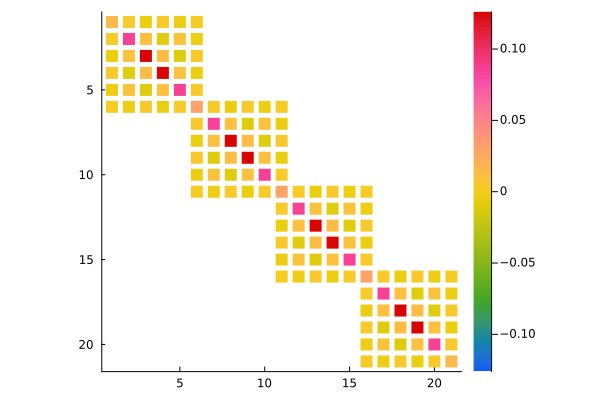

In [5]:
fe = FESpace(6, 6, 4, gausslobatto)
u0 = zero(fe.xn)
J1 = fe_jacobian(u0, fe, dfq_mass, bci=[], bcv=[])
fe = FESpace(6, 6, 4, gausslegendre)
J2 = fe_jacobian(u0, fe, dfq_mass, bci=[], bcv=[])
@show norm(J1 - diagm(diag(J1)))
@show norm(J2 - diagm(diag(J2)))
@show norm(sum(J2, dims=2) - diag(J1))
my_spy(J2)

# SUPG for time-dependent problems

$$\int_\Omega v \big( u_t + \mathbf w \cdot \nabla u \big) + \int_\Omega \nabla v \cdot \kappa \nabla u - \int_\Omega v s + \int_\Omega \tau^e (\mathbf w \cdot \nabla v) \big(u_t + \mathbf w \cdot \nabla u - \nabla\cdot(\kappa\nabla u) - s\big)$$

* There is a $u_t$ term in the stabilization, tested by a gradient of the test function. This means we can't create a simple explicit form
$$u_t = M^{-1} F(u)$$
* Some ad-hoc methods treat this term explicitly, which effectively lags this term. It can work, but limits the choice of time integrator and affects order of accuracy in time.
* One can use fully implicit methods with this formulation, usually written as $G(\dot u, u, t) = 0$. Generalized alpha (a second order scheme that can move continuously between midpoint and BDF2, which is L-stable) methods are popular.

* There is a strong  form $$\nabla\cdot(\kappa\nabla u)$$ appearing in stabilization.
* For linear elements, this is typically zero on each element.
  * Ignore the term (popular) or reconstruct it using neighbor cells (implementation complexity) and/or projection (extra work/communication).
* High order elements
  * If $\kappa$ is constant, $\kappa \nabla\cdot\nabla u$ can be implemented using second derivatives of the basis functions.
  * Or via projection
  * Should $\tau^e$ be constant or variable over the element?

# SUPG solver

In [6]:
wind = 1; k = 0
n = 100; h = 2 / n; Pe = abs(wind) * h / (2 * k)
tau = h / (2 * abs(wind)) * (coth(Pe) - 1 / Pe)
dfq_supg_mass(q, u, du, Du, Ddu) = du, tau * wind * du
dfq_supg(q, u, du, Du, Ddu) = wind * Ddu, k * Ddu + tau * wind * (wind * Ddu)

function supg_setup()
  fe = FESpace(2, 2, n); per(x) = (((1 + x) % 2) + 2) % 2 - 1
  exact(x, t) = exp(-((per(x-wind*t))/.15)^2)
  u0 = exact.(fe.xn, 0)
  M = fe_jacobian(u0, fe, dfq_supg_mass, bci=[], bcv=[])
  J = fe_jacobian(u0, fe, dfq_supg, bci=[], bcv=[])
  P = spdiagm(n+1, n, ones(n)); P[end, 1] = 1 # Periodicity
  A = -(P' * M * P) \ Matrix(P' * J * P)
  fe, P' * u0, A, P, exact
end
fe, u0, A, P, exact = supg_setup();

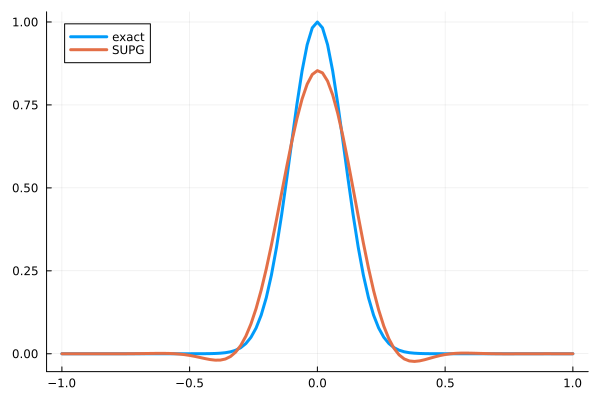

In [13]:
tfinal = 40
u = exp(A * tfinal) * u0
plot(fe.xn, [exact.(fe.xn, tfinal) P*u], label=["exact" "SUPG"], legend=:topleft)

# Spectrum of the operator

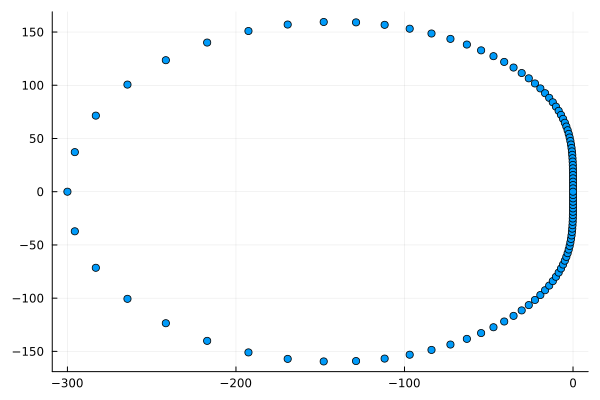

In [8]:
lam = eigvals(A)
scatter(real.(lam), imag.(lam), legend=:none)

# Demanding problem

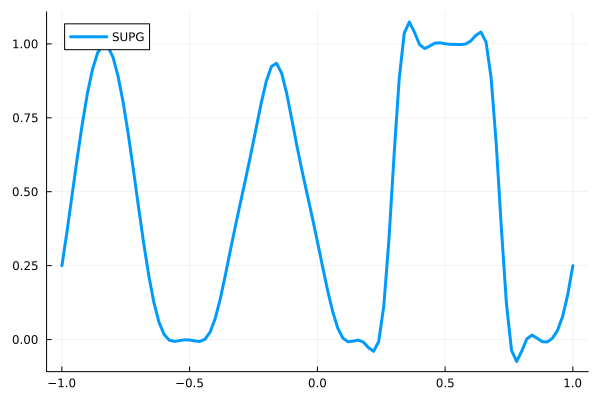

In [9]:
function testfunc(x)
    max(1 - 4*abs.(x+2/3),
        abs.(x) .< .2,
        (2*abs.(x-2/3) .< .5) * cospi(2*(x-2/3)).^2
    )
end

fe, u0, A, P = supg_setup();
u0 = P' * testfunc.(fe.xn)
tfinal = .5
u = exp(A * tfinal) * u0
plot(fe.xn, P*u, label="SUPG", legend=:topleft)

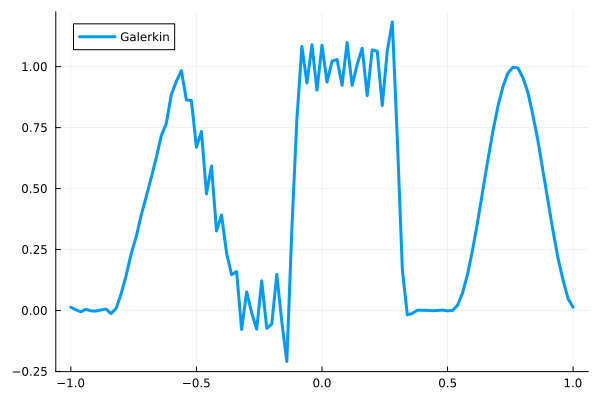

In [10]:
n = 100; h = 2 / n; Pe = abs(wind) * h / (2 * k)
tau = h / (2 * abs(wind)) * (coth(Pe) - 1 / Pe) * 0
fe, u0, A, P = supg_setup();
u0 = P' * testfunc.(fe.xn)
tfinal = 0.1
u = exp(A * tfinal) * u0
plot(fe.xn, P*u, label="Galerkin", legend=:topleft)

# Finite element interfaces: [Deal.II](https://dealii.org)

\begin{gather*}
    v^T F(u) \sim \int_\Omega v \cdot \color{olive}{f_0(u, \nabla u)} + \nabla v \!:\! \color{olive}{f_1(u, \nabla u)} \quad
    v^T J w \sim \int_\Omega \begin{bmatrix} v \\ \nabla v \end{bmatrix}^T \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}}
    \begin{bmatrix} w \\ \nabla w \end{bmatrix} \\
    J w = \sum_e \mathcal E_e^T \underbrace{\begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix}^T
    \begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right)^T \end{bmatrix}}_{\texttt{fe\_values}} W_q \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}} \underbrace{\begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right) \end{bmatrix} \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix}}_{\texttt{fe\_values}} \mathcal E_e w_L
\end{gather*}

* Deal.II [step-7](https://dealii.org/developer/doxygen/deal.II/step_7.html)

```python
for e in elems:
    fe_values.reinit()
    for q in q_points:
        for i in test_functions:
            for j in trial_functions
                K_e[i,j] += ...
            f_e[i] += ...
    for f in e.faces:
        if f.at_boundary():
            fe_face_values.reinit()
            for q in q_points:
                ...
```

![](https://dealii.org/images/wiki/gallery/Single_layer.jpeg)

